In [1]:
import time
from src.method_selector import MlMethodSelector, ClassicMethodSelector
from src.measurement_provider import MeasurementProvider
from src.serializer import SenMLCBORSerializer, SenMLJSONSerializer
from src.signal_generator import SignalGenerator
from sys import getsizeof
from src.metric import FeatureMetricEnum, SimilarityMetricEnum
from src.data_type import Measurement
import pandas as pd
import matplotlib as plt
from src.metric import SimilarityMetricEnum
import random
plt.rcParams["figure.dpi"] = 150
pd.set_option('display.max_columns', None)

In [2]:
def compute_sizes(dataset, compressed_data, metrics):
  senML_cbor_size_original = getsizeof(SenMLCBORSerializer.serialize(dataset, '/72/', '1/2', metrics))
  senML_cbor_size_compressed = getsizeof(SenMLCBORSerializer.serialize(compressed_data, '/72/', '1/2', metrics))
  senML_cbor_size_diff = senML_cbor_size_original - senML_cbor_size_compressed
  senML_cbor_size_ratio = senML_cbor_size_diff / senML_cbor_size_original

  senML_json_size_original = getsizeof(SenMLJSONSerializer.serialize(dataset, '/72/', '1/2', metrics))
  senML_json_size_compressed = getsizeof(SenMLJSONSerializer.serialize(compressed_data, '/72/', '1/2', metrics))
  senML_json_size_diff = senML_json_size_original - senML_json_size_compressed
  senML_json_size_ratio = senML_json_size_diff / senML_json_size_original
  return {
    'senML_cbor_size_original': senML_cbor_size_original,
    'senML_cbor_size_compressed': senML_cbor_size_compressed,
    'senML_cbor_size_diff': senML_cbor_size_diff,
    'senML_cbor_size_ratio': senML_cbor_size_ratio,

    'senML_json_size_original': senML_json_size_original,
    'senML_json_size_compressed': senML_json_size_compressed,
    'senML_json_size_diff': senML_json_size_diff,
    'senML_json_size_ratio': senML_json_size_ratio,
  }

def current_milis():
  return time.time() * 1000
  
def run_measurements(dataset, get_measurements):
  weights = {
    SimilarityMetricEnum.compression_rate: 3,
    SimilarityMetricEnum.sum_differences: 2,
    SimilarityMetricEnum.arithmetic_average: 2,
    SimilarityMetricEnum.standard_derivative: 1,
    SimilarityMetricEnum.function_field: 1,
    SimilarityMetricEnum.diff_of_min: 1,
    SimilarityMetricEnum.diff_of_max: 1,
    SimilarityMetricEnum.min_max_diff: 1,
    # SimilarityMetricEnum.value_crossing: 1,
    # SimilarityMetricEnum.positive_value_crossing: 1,
    # SimilarityMetricEnum.negative_value_crossing: 1,
    # SimilarityMetricEnum.peak_count: 1,
    # SimilarityMetricEnum.positive_peak_count: 1,
    # SimilarityMetricEnum.negative_peak_count: 1,
    SimilarityMetricEnum.median: 2,
    SimilarityMetricEnum.covariance: 1,
    SimilarityMetricEnum.corelation_pearson: 1,
    SimilarityMetricEnum.corelation_spearman: 1,
  }
  ml_method_selector = MlMethodSelector()
  ml_method_selector.use_weights_strategy(weights)
  ml_method_selector.set_measurements(dataset)
  score = ml_method_selector.train()
  print(score)

  naive_method_selector = ClassicMethodSelector()

  print("datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio")

  results = {
    "datasize": [],
    "ml_time": [],
    "naive_time": [],
    "ml_compressed_size": [],
    "naive_compressed_size": [],
    "ml_compression_ratio": [],
    "naive_compression_ratio": [],
    "ml_method": [],
    "naive_method": [],
    "ml_score": [],
    "naive_score": [],
    "ml_cbor_original_size": [],
    "ml_cbor_compressed_size": [],
    "ml_cbor_compressratio": [],
    "naive_cbor_original_size": [],
    "naive_cbor_compressed_size": [],
    "naive_cbor_compressratio": [],
    "ml_json_original_size": [],
    "ml_json_compressed_size": [],
    "ml_json_compressratio": [],
    "naive_json_original_size": [],
    "naive_json_compressed_size": [],
    "naive_json_compressratio": [],
  }

  for datasize in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    # measurements = measurement_provider.to_measurements(SignalGenerator(0, datasize).with_peaks(3).with_peaks(3, direction=-1).sin(0.2, 0.2))
    measurements = get_measurements(datasize)

    time_start = current_milis()
    compressed_data, stats, metrics = ml_method_selector.compress_with_best(measurements)
    time_end = current_milis()
    serialized_data_stats = compute_sizes(measurements, compressed_data, metrics)
    metrics_score = ClassicMethodSelector().compute_similarity_with_weights_strategy(measurements, compressed_data, weights)

    ml_time = time_end - time_start
    ml_compressed_size = stats['compressed_size']
    ml_compression_ratio = stats['compression_rate'] * 100
    ml_method = stats['method_name']
    ml_score = metrics_score
    ml_cbor_original_size = serialized_data_stats['senML_cbor_size_original']
    ml_cbor_compressed_size = serialized_data_stats['senML_cbor_size_compressed']
    ml_cbor_compressratio = serialized_data_stats['senML_cbor_size_ratio']
    ml_json_original_size = serialized_data_stats['senML_json_size_original']
    ml_json_compressed_size = serialized_data_stats['senML_json_size_compressed']
    ml_json_compressratio = serialized_data_stats['senML_json_size_ratio']

    results['datasize'].append(datasize);
    results['ml_time'].append(ml_time);
    results['ml_compressed_size'].append(ml_compressed_size);
    results['ml_compression_ratio'].append(ml_compression_ratio);
    results['ml_method'].append(ml_method);
    results['ml_score'].append(ml_score);
    results['ml_cbor_original_size'].append(ml_cbor_original_size);
    results['ml_cbor_compressed_size'].append(ml_cbor_compressed_size);
    results['ml_cbor_compressratio'].append(ml_cbor_compressratio);
    results['ml_json_original_size'].append(ml_json_original_size);
    results['ml_json_compressed_size'].append(ml_json_compressed_size);
    results['ml_json_compressratio'].append(ml_json_compressratio);

    ##############################################

    time_start = current_milis()
    compressed_data, stats, metrics, metrics_score = naive_method_selector.compress_with_best_weights_strategy(measurements, weights)
    time_end = current_milis()
    serialized_data_stats = compute_sizes(measurements, compressed_data, metrics)

    naive_time = time_end - time_start
    naive_compressed_size = stats['compressed_size']
    naive_compression_ratio = stats['compression_rate'] * 100
    naive_method = stats['method_name']
    naive_score = metrics_score
    naive_cbor_original_size = serialized_data_stats['senML_cbor_size_original']
    naive_cbor_compressed_size = serialized_data_stats['senML_cbor_size_compressed']
    naive_cbor_compressratio = serialized_data_stats['senML_cbor_size_ratio']
    naive_json_original_size = serialized_data_stats['senML_json_size_original']
    naive_json_compressed_size = serialized_data_stats['senML_json_size_compressed']
    naive_json_compressratio = serialized_data_stats['senML_json_size_ratio']

    results['naive_time'].append(naive_time);
    results['naive_compressed_size'].append(naive_compressed_size);
    results['naive_compression_ratio'].append(naive_compression_ratio);
    results['naive_method'].append(naive_method);
    results['naive_score'].append(naive_score);
    results['naive_cbor_original_size'].append(naive_cbor_original_size);
    results['naive_cbor_compressed_size'].append(naive_cbor_compressed_size);
    results['naive_cbor_compressratio'].append(naive_cbor_compressratio);
    results['naive_json_original_size'].append(naive_json_original_size);
    results['naive_json_compressed_size'].append(naive_json_compressed_size);
    results['naive_json_compressratio'].append(naive_json_compressratio);

    print(f'{datasize},{ml_time},{naive_time},{ml_compressed_size},{naive_compressed_size},{ml_compression_ratio},{naive_compression_ratio},{ml_method},{naive_method},{ml_score},{naive_score},{ml_cbor_original_size},{ml_cbor_compressed_size},{ml_cbor_compressratio},{naive_cbor_original_size},{naive_cbor_compressed_size},{naive_cbor_compressratio},{ml_json_original_size},{ml_json_compressed_size},{ml_json_compressratio},{naive_json_original_size},{naive_json_compressed_size},{naive_json_compressratio}')
  return pd.DataFrame.from_dict(results)

In [3]:
dataset = MeasurementProvider().get_random3()
# df = run_measurements(dataset, lambda datasize: MeasurementProvider().to_measurements(SignalGenerator(0, datasize).linear(2.5).sin(1, 0.2)))
df = run_measurements(dataset, lambda datasize: MeasurementProvider().to_measurements(SignalGenerator(0, datasize).with_peaks(4).with_peaks(3, direction=-1).sin(2, 0.2).linear(0.05).noise()))

(0.4666666666666667, 0.7333333333333333)
datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
100,1.482177734375,100.610107421875,30,40,70.0,60.0,CompressPIP_PD_0.3,CompressPIP_ED_0.4,83.6661,85.8697,2323,925,0.6018080068876452,2323,1125,0.5157124408092983,5402,1875,0.6529063309885228,5400,2378,0.5596296296296296
200,3.483154296875,271.4140625,80,80,60.0,60.0,CompressPIP_PD_0.4,CompressPIP_PD_0.4,85.8086,85.8086,4323,1924,0.554938699976868,4323,1924,0.554938699976868,10535,4457,0.5769340294257238,10535,4457,0.5769340294257238
300,4.686279296875,481.2666015625,120,61,60.0,79.66666666666666,CompressP

In [4]:
# df = pd.read_csv('./results2a.csv')
# df['ml_compression_ratio'] *= 100
# df['naive_compression_ratio'] *= 100

In [16]:
df1 = df
# df = df1
df

,datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
0,100,1.482178,100.610107,30,40,70.0,60.000000,CompressPIP_PD_0.3,CompressPIP_ED_0.4,83.6661,85.8697,2323,925,0.601808,2323,1125,0.515712,5402,1875,0.652906,5400,2378,0.559630
1,200,3.483154,271.414062,80,80,60.0,60.000000,CompressPIP_PD_0.4,CompressPIP_PD_0.4,85.8086,85.8086,4323,1924,0.554939,4323,1924,0.554939,10535,4457,0.576934,10535,4457,0.576934
2,300,4.686279,481.266602,120,61,60.0,79.666667,CompressPIP_PD_0.4,CompressNTHS_0.2,85.9351,87.2147,6324,2724,0.569260,6324,1545,0.755693,15638,6456,0.587159,15639,3434,0.780421
3,400,8.161865,840.230957,160,80,60.0,80.000000,CompressPIP_PD_0.4,CompressPIP_ED_0.2,81.1979,87.5318,8324,3523,0.576766,8324,1925,0.768741,20880,8581,0.589033,20850,4452,0.786475
4,500,21.197754,1185.382080,300,50,40.0,90.000000,CompressPIP_ED_0.6,CompressPIP_PD_0.1,84.5079,87.7077,10324,6325,0.387350,10324,1325,0.871658,25954,15697,0.395199,25939,2867,0.889471
5,600,12.367920,1659.008789,240,120,60.0,80.000000,CompressPIP_PD_0.4,CompressPIP_PD_0.2,86.4536,87.5900,12324,5126,0.584064,12324,2725,0.778887,31131,12657,0.593428,31131,6496,0.791333
6,700,13.859863,2137.288818,280,70,60.0,90.000000,CompressPIP_PD_0.4,CompressPIP_PD_0.1,85.9365,88.1030,14412,5956,0.586733,14412,1733,0.879753,36293,14737,0.593944,36335,4005,0.889776
7,800,17.954102,2605.200195,320,240,60.0,70.000000,CompressPIP_PD_0.4,CompressPIP_PD_0.3,86.1657,87.6108,16612,6828,0.588972,16612,5212,0.686251,41405,16798,0.594300,41402,12674,0.693880
8,900,18.788818,3288.177002,360,90,60.0,90.000000,CompressPIP_PD_0.4,CompressPIP_PD_0.1,84.6867,87.1895,18812,7686,0.591431,18812,2171,0.884595,46576,18887,0.594491,46576,5031,0.891983
9,1000,21.214111,3977.185059,400,100,60.0,90.000000,CompressPIP_PD_0.4,CompressPIP_PD_0.1,85.6553,87.8196,21012,8572,0.592043,21012,2389,0.886303,51667,20900,0.595486,51670,5498,0.893594


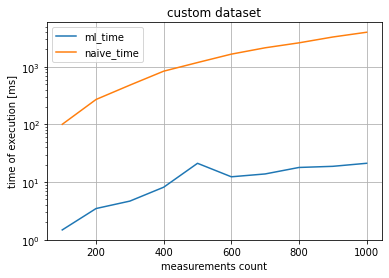

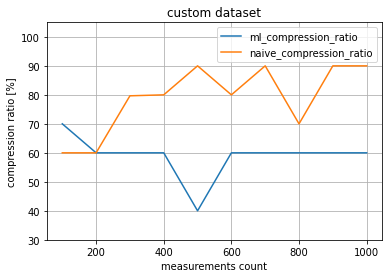

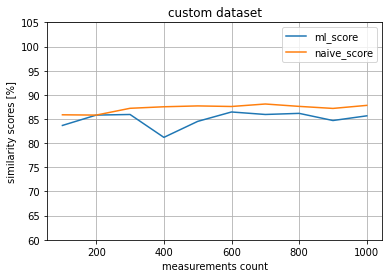

In [17]:
path = '../plot/strategy2'
ax = df.plot(x='datasize', y=['ml_time', 'naive_time'], grid=True)
ax.set_yscale("log")
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("time of execution [ms]")
ax.figure.savefig(f'{path}/1a.png')

ax = df.plot(x='datasize', y=['ml_compression_ratio', 'naive_compression_ratio'], grid=True)
ax.set_ylim(30, 105)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compression ratio [%]")
ax.figure.savefig(f'{path}/2a.png')

# ax = df.plot(x='datasize', y=['ml_compressed_size', 'naive_compressed_size'], grid=True)
# ax.set_title("custom dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("compresed measurement set count")
# ax.figure.savefig(f'{path}/3a.png')

ax = df.plot(x='datasize', y=['ml_score', 'naive_score'], grid=True)
ax.set_ylim(60, 105)
ax.set_title("custom dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("similarity scores [%]")
ax.figure.savefig(f'{path}/4a.png')

# ax = df.plot(x='datasize', y=['ml_cbor_compressed_size', 'naive_cbor_compressed_size', 'ml_json_compressed_size', 'naive_json_compressed_size'], grid=True, ylim=0)
# ax.set_title("custom dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("data size [B]")
# ax.figure.savefig(f'{path}/5a.png')


In [7]:
measurements1 = MeasurementProvider().json_to_measurements('stock1.json')
size1 = len(measurements1)
dataset = []
for i in range(10):
  start = int(random.randint(0, size1) * 0.7)
  end = random.randint(start, size1)
  dataset.append(measurements1[start:end])
df = run_measurements(dataset, lambda datasize: MeasurementProvider().json_to_measurements('stock1.json')[:datasize])

(0.0, 0.5)
datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
100,1.412109375,106.16015625,20,10,80.0,90.0,CompressPIP_PD_0.2,CompressPIP_PD_0.1,89.7231,90.0012,2529,769,0.6959272439699487,2529,549,0.7829181494661922,5745,1452,0.7472584856396867,5744,914,0.8408774373259053
200,2.934814453125,278.7958984375,40,20,80.0,90.0,CompressPIP_PD_0.2,CompressPIP_PD_0.1,88.6035,89.1151,4729,1209,0.7443434129837175,4729,769,0.8373863396066822,11121,2478,0.7771783113029404,11119,1405,0.8736397158017807
300,4.828369140625,508.868896484375,60,60,80.0,80.0,CompressPIP_PD_0.2,CompressPIP_PD_0.2,89.4008,89.4008,69

In [8]:
# df = pd.read_csv('./results2b.csv')
# df['ml_compression_ratio'] *= 100
# df['naive_compression_ratio'] *= 100

In [18]:
df2 = df
# df = df2
df

,datasize,ml_time,naive_time,ml_compressed_size,naive_compressed_size,ml_compression_ratio,naive_compression_ratio,ml_method,naive_method,ml_score,naive_score,ml_cbor_original_size,ml_cbor_compressed_size,ml_cbor_compressratio,naive_cbor_original_size,naive_cbor_compressed_size,naive_cbor_compressratio,ml_json_original_size,ml_json_compressed_size,ml_json_compressratio,naive_json_original_size,naive_json_compressed_size,naive_json_compressratio
0,100,1.412109,106.160156,20,10,80.0,90.0,CompressPIP_PD_0.2,CompressPIP_PD_0.1,89.7231,90.0012,2529,769,0.695927,2529,549,0.782918,5745,1452,0.747258,5744,914,0.840877
1,200,2.934814,278.795898,40,20,80.0,90.0,CompressPIP_PD_0.2,CompressPIP_PD_0.1,88.6035,89.1151,4729,1209,0.744343,4729,769,0.837386,11121,2478,0.777178,11119,1405,0.873640
2,300,4.828369,508.868896,60,60,80.0,80.0,CompressPIP_PD_0.2,CompressPIP_PD_0.2,89.4008,89.4008,6930,1649,0.762049,6930,1649,0.762049,16530,3555,0.784936,16530,3555,0.784936
3,400,6.157959,840.770264,80,40,80.0,90.0,CompressPIP_PD_0.2,CompressPIP_PD_0.1,90.4039,90.7778,9130,2089,0.771194,9130,1209,0.867579,21967,4651,0.788273,21999,2521,0.885404
4,500,7.251953,1049.432861,100,50,80.0,90.0,CompressPIP_PD_0.2,CompressPIP_PD_0.1,90.7959,91.0096,11330,2529,0.776787,11330,1429,0.873875,27366,5707,0.791457,27367,3006,0.890160
5,600,9.003174,1447.783936,120,60,80.0,90.0,CompressPIP_PD_0.2,CompressPIP_PD_0.1,90.0636,91.4386,13530,2969,0.780562,13530,1649,0.878123,32901,6865,0.791344,32900,3615,0.890122
6,700,9.916016,1913.162842,140,70,80.0,90.0,CompressPIP_PD_0.2,CompressPIP_PD_0.1,91.1356,91.4264,15730,3409,0.783280,15730,1869,0.881182,38264,7888,0.793853,38311,4145,0.891807
7,800,10.108887,2233.694092,80,80,90.0,90.0,CompressPIP_PD_0.1,CompressPIP_PD_0.1,91.4004,91.4004,17930,2089,0.883491,17930,2089,0.883491,43700,4669,0.893158,43700,4669,0.893158
8,900,12.007324,2828.852051,90,90,90.0,90.0,CompressPIP_PD_0.1,CompressPIP_PD_0.1,91.7483,91.7483,20130,2309,0.885296,20130,2309,0.885296,49192,5186,0.894576,49192,5186,0.894576
9,1000,12.927002,3468.288086,100,200,90.0,80.0,CompressPIP_PD_0.1,CompressPIP_PD_0.2,90.5914,91.0149,22330,2529,0.886744,22330,4729,0.788222,54744,5745,0.895057,54743,11188,0.795627


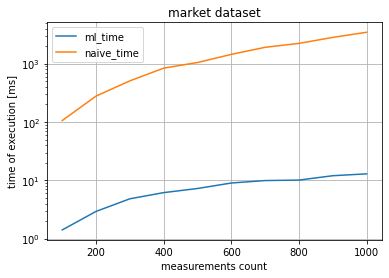

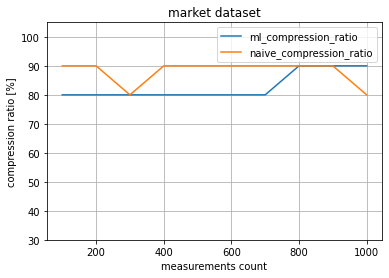

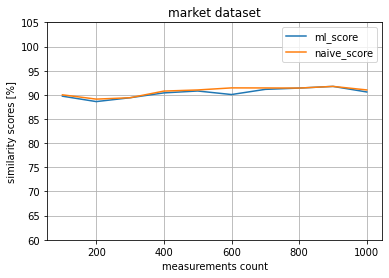

In [19]:
path = '../plot/strategy2'
ax = df.plot(x='datasize', y=['ml_time', 'naive_time'], grid=True)
ax.set_yscale("log")
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("time of execution [ms]")
ax.figure.savefig(f'{path}/1b.png')

ax = df.plot(x='datasize', y=['ml_compression_ratio', 'naive_compression_ratio'], grid=True)
ax.set_ylim(30, 105)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("compression ratio [%]")
ax.figure.savefig(f'{path}/2b.png')

# ax = df.plot(x='datasize', y=['ml_compressed_size', 'naive_compressed_size'], grid=True)
# ax.set_title("market dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("compresed measurement set count")
# ax.figure.savefig(f'{path}/3b.png')

ax = df.plot(x='datasize', y=['ml_score', 'naive_score'], grid=True)
ax.set_ylim(60, 105)
ax.set_title("market dataset")
ax.set_xlabel("measurements count")
ax.set_ylabel("similarity scores [%]")
ax.figure.savefig(f'{path}/4b.png')

# ax = df.plot(x='datasize', y=['ml_cbor_compressed_size', 'naive_cbor_compressed_size', 'ml_json_compressed_size', 'naive_json_compressed_size'], grid=True, ylim=0)
# ax.set_title("market dataset")
# ax.set_xlabel("measurements count")
# ax.set_ylabel("data size [B]")
# ax.figure.savefig(f'{path}/5b.png')

